# Assignment 10

### 1.复习上课内容

## 贝叶斯分类器
- 垃圾邮件的鉴别
- 贝叶斯法则公式
    $$ P(A|B) = \frac{P(A|B)}{P(B)} = \frac{P(B|A)P(A)}{P(B)}$$ 
- 全概率公式
    $$ P(A) = \sum{P(A|B_i)P(B_i)}$$

## K-means
- 无监督聚类
- 开始先随机选取K个类别，然后计算其他每个点到这K个点的距离，把近的点归为一类，然后重新计算这K个类别点中心点。然后反复重复上述操作，直至上述点不再更新


## SVM
- 数学
- 是一种二分类模型，基本模型是定义在特征空间上的间隔最大的线性分类器，其基本想法是求解能够正确划分训练数据集并且几何间隔最大的分离超平面。


## Ensemble learning 集成学习
- 人多力量大
- Bagging:少数服从多数
- boosting：一开始权重一样，通过数据是否判断正确，如果判断错误，权重升高，判断正确，权重降低，通过预测值不断迭代权重。每次学完就会去看这个算法对数据的影响，下一个算法通过权重修改，希望对错误对数据有更多关注
- 随机森林：多个树，每个树对样本都有一个判断。使用Bootstrap进行采样
- XGboost：回归树，结果是数值，不是类别
也是通过构建树，需要计算残差。

### 2. 回答一下理论题目

#### 1. What is independent assumption in Naive bayes ?

假设事件发生的概率之间是相互独立的 ；朴素：独立假设 

#### 2. What is MAP(maximum a posterior) and ML(maximum likelihood) ?

**MAP:** 最大化后验概率，在给定一系列数据时，从这些数据中选择出最有可能的数据。

h: hypothesis space{f},所有可能的函数,每个函数对应一个预测值，如果f是线性的，则该含义就是从所有线性函数中选择一条线性函数出来。
D:数据集,因为数据集是固定的，所以P(D)是一个常数，分母可以去掉。
$$h_{MAP} = argmaxP(h|D)=argmax\frac{P(D|h)P(h)}{P(D)}=argmaxP(D|h)P(h)$$

**ML：** 最大化期望值
p(h)是指函数发生可能的假设概率。如果P(h)是一个常数，就是指h是一样的，没有任何偏好，无差别的，这是就可以进一步化简上面的公式，这就是最大化期望值
$$h_{ML} = argmaxP(D|h)P(h)$$

#### 3. What is support vector in SVM?

- 支持向量是指虚线边界上的点
- 距离超平面最近的点称为支持向量

#### 4. What is the intuition behind SVM ?

- 使所有点之间间距最大化

#### 5. Shortly describ what 'random' means in random forest ?

使用随机森林训练数据时，需要进行随机采样，这样可以保证训练数据之间的差异化

#### 6. What cariterion does XGBoost use to find the best split point in a tree ?

重点：寻找最优化分点
1. 用什么划分
2. 该不该划分
目标函数： $$Obj=\sum_{i=1}^{n}l(y_i, \hat y_i) + \sum_{k=1}^{K}\Omega(f_k) $$

其中

l: 是指损失函数,判断预测值和真实值之间的差别，可以用交叉熵等
Ω: 正则化，是一个惩罚项，让树不要太深，因为太深可能分的过细

$$Ω(f_t)=\gamma^T+\frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2$$

𝑤:每个叶子的权重
𝛾：惩罚系数
T: 叶子数量

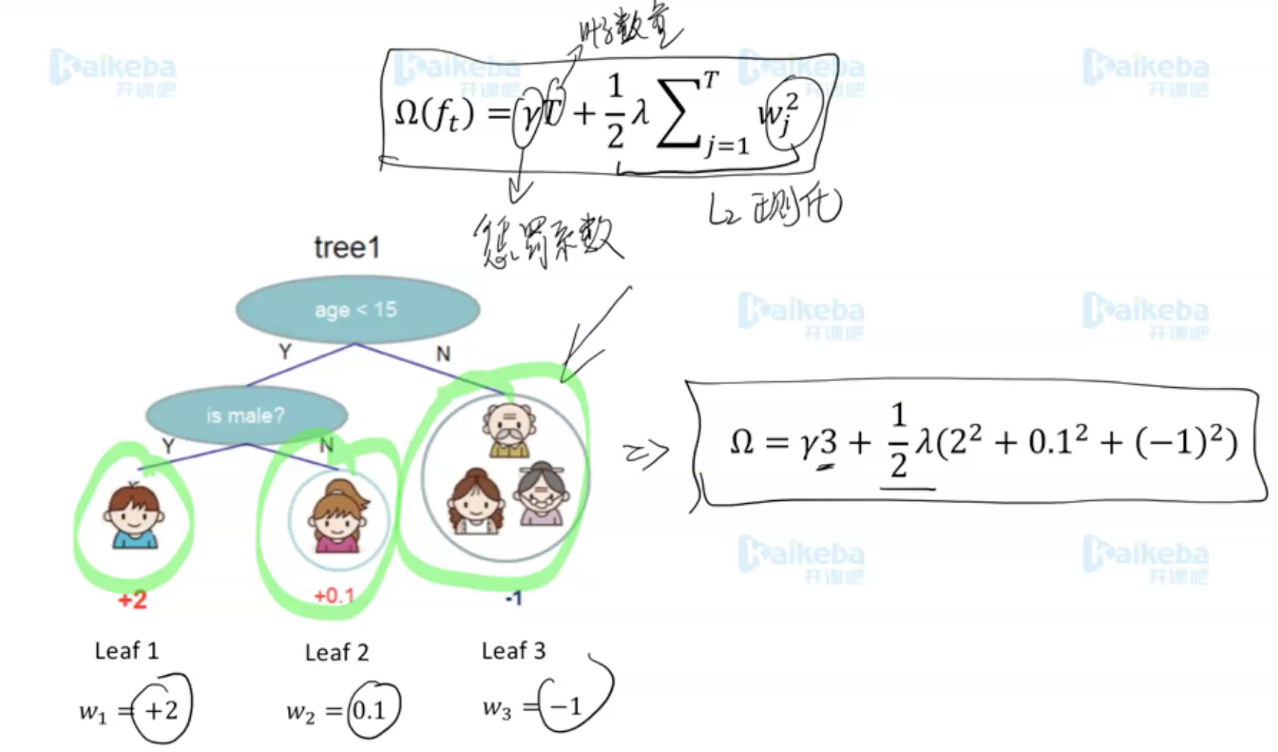

### 3. Practial part

##### Problem description: In this part you are going to build a classifier to detect if a piece of news is published by the Xinhua news agency (新华社）.

## 问题分析
1. 2分类问题
2. 机器学习算法，SVM\随机森林\逻辑回归


#### Hints:

###### 1. Firstly, you have to come up with a way to represent the news. (Vectorize the sentence, you can find different ways to do so online)  

### 工具包导入

In [3]:
!pip install gensim

    100% |████████████████████████████████| 24.2MB 20kB/s ta 0:00:0104
  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='pypi.org', port=443): Read timed out. (read timeout=15)")': /simple/smart-open/
    100% |████████████████████████████████| 112kB 22kB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 11kB/s ta 0:00:0103
    100% |████████████████████████████████| 6.2MB 15kB/s ta 0:00:012
  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='pypi.org', port=443): Read timed out. (read timeout=15)")': /simple/s3transfer/
    100% |████████████████████████████████| 71kB 6.5kB/s ta 0:00:02
  Stored in directory: /Users/stone/Library/Caches/pip/wheels/27/65/38/8d7f5fe8d7afb4e4566587b2d1933cec185fba19257836c943
Successfully built smart-open


In [6]:
!pip install xgboost

    100% |████████████████████████████████| 829kB 18kB/s ta 0:00:0184
  Stored in directory: /Users/stone/Library/Caches/pip/wheels/2d/88/a6/eae5e2f880d228c2e8c057a2b166a05306f41e1ceaa2a01b45
Successfully built xgboost


In [9]:
import numpy as np
import pandas as pd
from joblib import Parallel,delayed # 多进程处理
import time
import jieba
import re

from gensim.models import FastText # 词向量
from gensim.models import doc2vec # 生成文本向量

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

/Users/stone/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### 数据预处理

In [46]:
data = pd.read_csv("xinhua_news.csv", encoding="gb18030")

In [47]:
data.head(n=10)

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm
3,89614,NaN,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""j...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126....
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875...
5,89612,张怡,中国证券报?中证网,受到A股被纳入MSCI指数的利好消息刺激，A股市场从周三开始再度上演龙马行情，周四上午金...,"{""type"":""市场"",""site"":""中证网"",""commentNum"":""0"",""jo...",金融股一枝独秀 配置价值犹存,http://www.cs.com.cn/gppd/201706/t20170623_533...
6,89611,NaN,威锋网@http://www.feng.com/,虽然至今夏普智能手机在市场上无法排得上号，已经完全没落，并于 2013 年退出中国市场，但是...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""21""...",配骁龙660 全面屏鼻祖夏普新机酝酿中,http://www.cnbeta.com/articles/tech/623603.htm
7,89610,申玉彬 整理,中国证券报?中证网,沙漠雄鹰：震荡有利消化套牢筹码\r\n 周四开盘上证50在银行券商大蓝筹带动下一度涨近...,"{""type"":""市场"",""site"":""中证网"",""commentNum"":""0"",""jo...",博友早评：震荡有利消化套牢筹码,http://www.cs.com.cn/gppd/201706/t20170623_533...
8,89609,李杭_BJS4645,荆楚网-楚天都市报,（原标题：武汉警方一下子抓了808人，还都是俊男靓女！原来他们每天偷偷摸摸干这事！）\r\n...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""1600""...",武汉千余警察出动 抓获808名俊男靓女全是诈骗犯,http://news.163.com/17/0614/14/CMT9N8G80001899...
9,89608,吴瞬,中国证券报?中证网,6月21日，A股纳入MSCI指数尘埃落定，但当天被寄予厚望的券商股并未扛起反弹大旗。22...,"{""type"":""市场"",""site"":""中证网"",""commentNum"":""0"",""jo...",纳入MSCI指数 A股长期配置价值提升,http://www.cs.com.cn/gppd/201706/t20170623_533...


In [48]:
data.columns

Index(['id', 'author', 'source', 'content', 'feature', 'title', 'url'], dtype='object')

In [49]:
data.iloc[24]

id                                                     89593
author                                             屠震林 PS040
source                                                  凤凰体育
content    北京时间6月20日，江苏苏宁足球俱乐部发布了足协杯第四轮江苏苏宁易购队主场对阵河南建业队的官...
feature    {"type":"体育","site":"凤凰","commentNum":"1","joi...
title                              “齐心协力”--江苏苏宁发布足协杯对阵河南建业海报
url        http://sports.ifeng.com/a/20170620/51284188_0....
Name: 24, dtype: object

In [58]:
print(type(data['source']))

<class 'pandas.core.series.Series'>


In [59]:
data.drop(['author', 'url'], axis=1, inplace=True)

In [60]:
data['content'].isna().sum()

2557

In [61]:
data['source'].isna().sum()

2

In [62]:
# 查看特征统计
data.describe(include='O')

,source,content,feature,title
count,89609,87054,89611,89577
unique,974,74917,89184,85253
top,新华社,\n\n,"{""commentNum"":""2"",""forwardNum"":""7"",""playNum"":""...",国际重要稿件预告
freq,78661,177,3,219


In [63]:
data[data['content'] == '\\n\\n'].head()

,id,source,content,feature,title
11315,78297,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",广州青岛调控加码：不动产证满两年方可交易
12294,77318,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",河北雄安新区来了！你想知道的都在这里
15615,73997,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",中国实业转型升级竞逐全球的新“联想”
15880,73732,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",前有深圳、浦东，今天的雄安新区潜力有多大
20022,69590,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",图解丨“垃圾分类”时代来了 你知道怎么分吗？


In [66]:
data[data['content'] == '\\n\\n'].iloc[-1]['feature']

'{"type":"其它","site":"新华社","url":"http://home.xinhua-news.com/gdsdetailxhsnew/2198960-?pageflag=init&imageOrVedioTypeGdsId=","site_sign":"xinhua","keywords":"-","summary":"","rich_label":"[]","all_type":"新媒体,新媒体专线\\r\\n","issuing_department":"","id":"2198960","no":"200012017060601198251","word_count":"0","related_areas":"","reported_area":"","imgUrls":"noImage"}'

数据不均衡，需要进行下采样，

In [67]:
data[data['content'] == '\\n\\n'].head()

,id,source,content,feature,title
11315,78297,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",广州青岛调控加码：不动产证满两年方可交易
12294,77318,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",河北雄安新区来了！你想知道的都在这里
15615,73997,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",中国实业转型升级竞逐全球的新“联想”
15880,73732,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",前有深圳、浦东，今天的雄安新区潜力有多大
20022,69590,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",图解丨“垃圾分类”时代来了 你知道怎么分吗？


In [70]:
def replace_content_with_title(row):
    row.content = row.title
    return row

In [71]:
data[data['content'] == '\\n\\n'] = data[data['content'] == '\\n\\n'].apply(replace_content_with_title, axis=1)

In [72]:
data[data['source'].isna()]

,id,source,content,feature,title
4960,84657,NaN,投服中心四问万盛股份\r\n □本报记者 周松林 徐金忠 官平\r\n 6月21日，在...,"{""type"":""公司"",""site"":""中证网"",""commentNum"":""0"",""jo...",收购匠芯知本拟双主业运行
9997,79620,NaN,????搜狐传媒讯，作为一档非选秀节目，新一季《中国梦想秀》将于4月5日开播，有关赛制和梦想...,"{""type"":""新闻"",""site"":""百度"",""commentNum"":""0"",""joi...",中国梦想秀助梦团-雨轩范文网


从feature中可以看出source为空的数据来源为中证网和百度，直接当做负类处理即可。  

In [73]:
data[data['content'].isna()].head()

,id,source,content,feature,title
100,89517,中国证券报?中证网,NaN,"{""type"":""公司"",""site"":""中证网"",""commentNum"":""0"",""jo...",天和防务股东未来6个月内计划减持不超过480万股公司股份
103,89514,中国证券报?中证网,NaN,"{""type"":""公司"",""site"":""中证网"",""commentNum"":""0"",""jo...",晶盛机电调整限制性股票回购价格
997,88620,央广网,NaN,"{""type"":""时事要闻"",""site"":""参考消息"",""commentNum"":""0"",...",[主播不在家]第二季：主播陈亮体验垃圾清运
1273,88344,央广网,NaN,"{""type"":""IT业界"",""site"":""参考消息"",""commentNum"":""0"",...",LKK洛可可：想象力经济时代或已到来
1282,88335,央广网,NaN,"{""type"":""IT业界"",""site"":""参考消息"",""commentNum"":""0"",...",CES2017：京东发布两款叮咚智能音箱新品 开放Alpha平台


数据不均衡，89611条数据中，有78661条是新华社发布的，需要进行下采样或者调整类别权重，避免全部预测为正例还能获得很高的分数。  
有177条数据的content为\n\n，对应的feature中summary也基本为空，使用title进行替换。

In [78]:
# 所有source来源
data.source.unique()

array(['快科技@http://www.kkj.cn/', '新华社', '深圳大件事', '中国证券报?中证网',
       '威锋网@http://www.feng.com/', '荆楚网-楚天都市报', '证券时报网', '中国新闻网', '国际在线',
       '中国证券网', 'solidot@', '新华网', '泡泡网', '凤凰体育', '雷锋网@', '中超球评',
       '中国经济周刊', '人民日报', '央广网', '体育君', '新浪体育',
       '雷锋网@http://www.leiphone.com/', '广州日报', 'TechWeb@', '足球小志', '人民网',
       '时代财经@', '新疆日报', '中关村在线@', '网易科技@http://tech.163.com/', '封面新闻',
       '央视新闻', '澎湃新闻网@', '澎湃新闻网', '中青在线', '央视新闻客户端@', '千龙网', '新华社@',
       '新浪综合@', '中新网', 'GamerSky游民星空@http://www.gamersky.com/', '中国经济网',
       'cnBeta.COM', '热点体育', '枪炮篮球PiU', '中国网财经',
       '知客数码@http://www.zaeke.com/article-7066-1.html',
       '于斌@http://www.chaoqi.net/', '霍寿喜', '网易科学人@', '看看新闻KNEWS', '新浪综合',
       '最后一公里', '伊吾零距离', '环球时报-环球网', '经济日报', '足球部落国际版', '参考消息网', '黑龙江日报',
       '解放军报', '环球网', '星城古龙', '凤凰网科技@', '每日经济新闻@', '新浪科技@', '经济参考报',
       '每日经济新闻', '三十年莱斯特城球', '中国科技网', '柳州新闻网', '中国新闻网@', '新京报即时新闻',
       'CCTV-央视网@http://www.cctv.com', '新闻晨报', '北青网-北京青年报', 'linkgou.com',

In [74]:
# 将内容为空，所涉及的source显示出来
data[data['content'].isna()].source.unique()

array(['中国证券报?中证网', '央广网', '中国台湾网', '海南日报第016版', '海南日报第015版', '海南日报第013版',
       '海南日报第012版', '海南日报第011版', '海南日报第010版', '郑州日报第11版', '海南日报第009版',
       '海南日报第005版', '海南日报第004版', '南方日报第01版', '海南日报第002版', '中国新闻网',
       '海南日报第001版', '郑州日报第01版', '长江日报第24版', '长江日报第23版', '海南日报第018版',
       '海南日报第017版', '海南日报第014版', '郑州日报第03版', '微博', '知乎'], dtype=object)

In [79]:
# 提取出source和content两列
data=data[['source', 'content']]

In [80]:
data

,source,content
0,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...
1,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...
2,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...
3,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n
4,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...
5,中国证券报?中证网,受到A股被纳入MSCI指数的利好消息刺激，A股市场从周三开始再度上演龙马行情，周四上午金...
6,威锋网@http://www.feng.com/,虽然至今夏普智能手机在市场上无法排得上号，已经完全没落，并于 2013 年退出中国市场，但是...
7,中国证券报?中证网,沙漠雄鹰：震荡有利消化套牢筹码\r\n 周四开盘上证50在银行券商大蓝筹带动下一度涨近...
8,荆楚网-楚天都市报,（原标题：武汉警方一下子抓了808人，还都是俊男靓女！原来他们每天偷偷摸摸干这事！）\r\n...
9,中国证券报?中证网,6月21日，A股纳入MSCI指数尘埃落定，但当天被寄予厚望的券商股并未扛起反弹大旗。22...


In [81]:
# 生成标签，如果是新华社则是1，如果不是标记为0
def generate_label(source, include_website=False):
    if not source:
        return 0
    if include_website and re.search('新华[社|网]', str(source)):
        return 1
    elif re.search('新华社', str(source)):
        return 1
    else:
        return 0

In [82]:
data.source = data.source.apply(generate_label)

In [83]:
data.columns = ['label', 'content']

In [84]:
data.head(n=15)

,label,content
0,0,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...
1,0,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...
2,0,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...
3,1,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n
4,0,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...
5,0,受到A股被纳入MSCI指数的利好消息刺激，A股市场从周三开始再度上演龙马行情，周四上午金...
6,0,虽然至今夏普智能手机在市场上无法排得上号，已经完全没落，并于 2013 年退出中国市场，但是...
7,0,沙漠雄鹰：震荡有利消化套牢筹码\r\n 周四开盘上证50在银行券商大蓝筹带动下一度涨近...
8,0,（原标题：武汉警方一下子抓了808人，还都是俊男靓女！原来他们每天偷偷摸摸干这事！）\r\n...
9,0,6月21日，A股纳入MSCI指数尘埃落定，但当天被寄予厚望的券商股并未扛起反弹大旗。22...


### 进一步文本预处理

In [104]:
# 读取停用词
with open("stopwords.txt", encoding="utf-8-sig") as f:
    stopwords = [line.strip() for line in f.readlines()]

In [113]:
stopwords

['一',
 '一下',
 '一个',
 '一些',
 '一何',
 '一切',
 '一则',
 '一则通过',
 '一天',
 '一定',
 '一方面',
 '一旦',
 '一时',
 '一来',
 '一样',
 '一次',
 '一片',
 '一番',
 '一直',
 '一致',
 '一般',
 '一起',
 '一转眼',
 '一边',
 '一面',
 '七',
 '万一',
 '三',
 '三天两头',
 '三番两次',
 '三番五次',
 '上',
 '上下',
 '上升',
 '上去',
 '上来',
 '上述',
 '上面',
 '下',
 '下列',
 '下去',
 '下来',
 '下面',
 '不',
 '不一',
 '不下',
 '不久',
 '不了',
 '不亦乐乎',
 '不仅',
 '不仅...而且',
 '不仅仅',
 '不仅仅是',
 '不会',
 '不但',
 '不但...而且',
 '不光',
 '不免',
 '不再',
 '不力',
 '不单',
 '不变',
 '不只',
 '不可',
 '不可开交',
 '不可抗拒',
 '不同',
 '不外',
 '不外乎',
 '不够',
 '不大',
 '不如',
 '不妨',
 '不定',
 '不对',
 '不少',
 '不尽',
 '不尽然',
 '不巧',
 '不已',
 '不常',
 '不得',
 '不得不',
 '不得了',
 '不得已',
 '不必',
 '不怎么',
 '不怕',
 '不惟',
 '不成',
 '不拘',
 '不择手段',
 '不敢',
 '不料',
 '不断',
 '不日',
 '不时',
 '不是',
 '不曾',
 '不止',
 '不止一次',
 '不比',
 '不消',
 '不满',
 '不然',
 '不然的话',
 '不特',
 '不独',
 '不由得',
 '不知不觉',
 '不管',
 '不管怎样',
 '不经意',
 '不胜',
 '不能',
 '不能不',
 '不至于',
 '不若',
 '不要',
 '不论',
 '不起',
 '不足',
 '不过',
 '不迭',
 '不问',
 '不限',
 '与',
 '与其',
 '与其说',
 '与否',
 '与此同时',
 '专门',
 '且',
 '且不说',
 '且说',
 '两者',
 '严

分词

In [132]:
def cut(content, stopwords):
    segs_words = jieba.cut(content)
    filters = []
    for word in segs_words:
        if word not in stopwords:
            filters.append(word)
        else:
            filters = segs_words
    return " ".join(filters)

In [154]:
data2 = data.loc[:, 'content']

In [155]:
data2

0        此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...
1        骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...
2        此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...
3          这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n
4        （原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...
5        　　受到A股被纳入MSCI指数的利好消息刺激，A股市场从周三开始再度上演龙马行情，周四上午金...
6        虽然至今夏普智能手机在市场上无法排得上号，已经完全没落，并于 2013 年退出中国市场，但是...
7        　　沙漠雄鹰：震荡有利消化套牢筹码\r\n　　周四开盘上证50在银行券商大蓝筹带动下一度涨近...
8        （原标题：武汉警方一下子抓了808人，还都是俊男靓女！原来他们每天偷偷摸摸干这事！）\r\n...
9        　　6月21日，A股纳入MSCI指数尘埃落定，但当天被寄予厚望的券商股并未扛起反弹大旗。22...
10       　　证券时报网（www.stcn.com）06月23日讯\r\n　　据上证报道，6月初以来，...
11       ?\r\n　　巨丰早评：市场将再次探底\r\n　　【巨丰观点】\r\n　　周四大盘冲高回落，...
12       中新网6月19日电 据外媒报道，美国底特律一名男子1976年因为一根头发被定谋杀罪，监禁41...
13       　　曹先生：风格转换前的阵痛\r\n　　今日早盘两地低开，之后一度震荡走高，领涨的仍然是上证...
14       6月21日，MSCI在官网发布公告称，从明年6月起将中国A股纳入MSCI新兴市场指数和MSC...
15       　　中国证券网讯（记者 费天元）沪深两市周五临近午盘出现快速跳水，沪指连续跌穿5日、10日及...
16       九成以上的源包用逐位对应的方式构建，未来版本的 Debian 还将提供验证包的工具和元数据；.

In [133]:
data["content"]

0        此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...
1        骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...
2        此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...
3          这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n
4        （原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...
5        　　受到A股被纳入MSCI指数的利好消息刺激，A股市场从周三开始再度上演龙马行情，周四上午金...
6        虽然至今夏普智能手机在市场上无法排得上号，已经完全没落，并于 2013 年退出中国市场，但是...
7        　　沙漠雄鹰：震荡有利消化套牢筹码\r\n　　周四开盘上证50在银行券商大蓝筹带动下一度涨近...
8        （原标题：武汉警方一下子抓了808人，还都是俊男靓女！原来他们每天偷偷摸摸干这事！）\r\n...
9        　　6月21日，A股纳入MSCI指数尘埃落定，但当天被寄予厚望的券商股并未扛起反弹大旗。22...
10       　　证券时报网（www.stcn.com）06月23日讯\r\n　　据上证报道，6月初以来，...
11       ?\r\n　　巨丰早评：市场将再次探底\r\n　　【巨丰观点】\r\n　　周四大盘冲高回落，...
12       中新网6月19日电 据外媒报道，美国底特律一名男子1976年因为一根头发被定谋杀罪，监禁41...
13       　　曹先生：风格转换前的阵痛\r\n　　今日早盘两地低开，之后一度震荡走高，领涨的仍然是上证...
14       6月21日，MSCI在官网发布公告称，从明年6月起将中国A股纳入MSCI新兴市场指数和MSC...
15       　　中国证券网讯（记者 费天元）沪深两市周五临近午盘出现快速跳水，沪指连续跌穿5日、10日及...
16       九成以上的源包用逐位对应的方式构建，未来版本的 Debian 还将提供验证包的工具和元数据；.

In [153]:
cut("朝鲜半岛西北部古元古代高温变质-深熔作用:宏观和微观岩石学以及锆石U-Pb年代学制约", stopwords)

AttributeError: 'generator' object has no attribute 'append'

In [147]:
def cut_it(content, stopwords=None):
    words = jieba.cut(content)
    # 过滤停用词
    if stopwords:
        print("here")
        filter_words = [word for word in words if word not in stopwords]
    else:
        filter_words = words
    return " ".join(filter_words)

In [148]:
# content内容进行替换
def clean(data, stopwords):
    data['content'] = data['content'].apply(cut_it, stopwords=stopwords)
    return data



In [149]:
clean(data,stopwords)

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


AttributeError: 'float' object has no attribute 'decode'

### data.groupby
聚合，分组级运算

In [150]:
def parallel_apply(data, func, stopwords):
    groups = data.groupby(data.index)
    results = Parallel(n_jobs=4)(delayed(func)(group, stopwords) for n, group in groups)
    return pd.concat(results)

In [151]:
# 分词多线程时间
s = time.time()
data = parallel_apply(data, clean, stopwords=None)
e = time.time()
diff = e - s
print("%.2f seconds cost for word cutting" % diff)

AttributeError: 'float' object has no attribute 'decode'

In [152]:
data.head()

,label,content
0,0,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...
1,0,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...
2,0,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...
3,1,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n
4,0,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...


In [103]:
data.to_csv("processed_data.csv", index=False)

In [8]:
# 查找出所有特征标签
# 提取出source字段的所有特征，并存储于




###### 2. Secondly,  pick a machine learning algorithm that you think is suitable for this task

### Congratulations! You have completed all assignments in this week. The question below is optional. If you still have time, why don't try it out.

## Option:

#### Try differnt machine learning algorithms with different combinations of parameters in the practical part, and compare their performances (Better use some visualization techiniques).